# Intro to Data

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
jeopardy = pd.read_csv("jeopardy.csv")
jeopardy.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


# Data Cleaning

In [38]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [39]:
jeopardy.columns = ["Show Number", "Air Date", "Round", "Category", "Value", "Question", "Answer"]
jeopardy.dtypes

Show Number     int64
Air Date       object
Round          object
Category       object
Value          object
Question       object
Answer         object
dtype: object

In [40]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    return text



In [41]:
jeopardy["clean_question"] = jeopardy["Question"].apply(normalize_text)
jeopardy["clean_answer"] = jeopardy["Answer"].apply(normalize_text)

In [42]:
def normalize_value(text):
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    try:
        text = int(text)
    except Exception:
        text = 0
    return text


In [43]:
jeopardy["clean_value"] = jeopardy["Value"].apply(normalize_value)


In [44]:
jeopardy["Air Date"] = pd.to_datetime(jeopardy["Air Date"])
jeopardy.dtypes

Show Number                int64
Air Date          datetime64[ns]
Round                     object
Category                  object
Value                     object
Question                  object
Answer                    object
clean_question            object
clean_answer              object
clean_value                int64
dtype: object

# Data Analysis

# Top Ten Topics in terms of questions asked

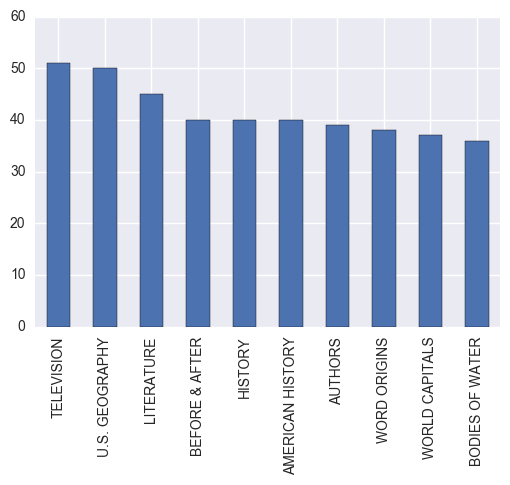

In [59]:
topics=jeopardy["Category"].value_counts()[:10]
topics.plot(kind="bar")

# Top Ten Topics in terms of money allocated

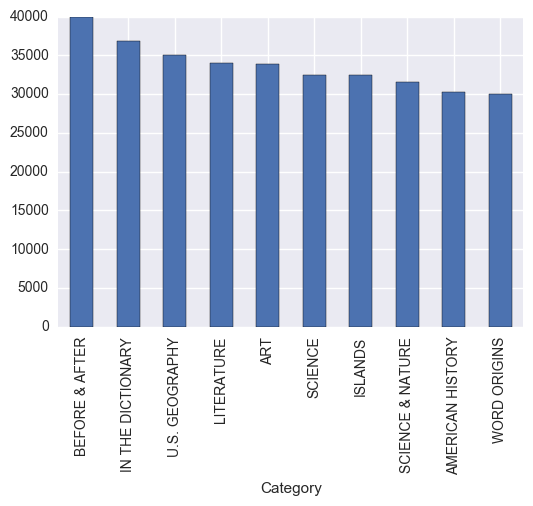

In [58]:
topics_money=jeopardy.groupby("Category")["clean_value"].sum().sort_values(ascending=False)[:10]
topics_money.plot(kind="bar")


In [64]:
common_topics=set(topics.index).intersection(list(topics_money.index))
print(common_topics)

{'U.S. GEOGRAPHY', 'LITERATURE', 'AMERICAN HISTORY', 'BEFORE & AFTER', 'WORD ORIGINS'}


# Topic Strategy

The Topics common to both high amount allocated and no of questions asked are: Before and After, U.S. Geography, Literature, American History, Word Origins. It will be a good strategy to prepare more from these topics.

In [47]:
def match_count(row):
    split_answer = row["clean_answer"].split(" ")
    split_question = row["clean_question"].split(" ")
    match_count = 0
    if "the" in split_answer:
        split_answer.remove("the")
    if len(split_answer) == 0:
        return 0
    else:
        for i in split_answer:
            if i in split_question:
                match_count = match_count + 1
        return match_count/len(split_answer)

In [48]:
jeopardy["answer_in_question"] = jeopardy.apply(match_count, axis=1)
answer_in_question_mean = jeopardy["answer_in_question"].mean()
print(answer_in_question_mean)

0.060493257069335914


# Answer in Question
Answer only appears in the question for just 6% of the time. Hence this strategy wont give any favourable returns.


In [49]:
#jeopardy.sort("Air Date", inplace=True)
question_overlap = []
terms_used = set()
for i, row in jeopardy.iterrows():
    split_question = row["clean_question"].split(" ")
    split_question = [q for q in split_question if len(q) > 5]
    match_count = 0
    for word in split_question:
        if word in terms_used:
            match_count +=1
        terms_used.add(word)
    if len(split_question) > 0:
        match_count = match_count/len(split_question)
    question_overlap.append(match_count)
    
jeopardy["question_overlap"] = question_overlap
print(jeopardy["question_overlap"].mean())

0.6925960057338565


# Question Overlap
69% of the questions overlap in terms of the words used. Since this is not a phrase comparison it needs to be investigated further.

In [50]:
def value(row):
    if row["clean_value"] > 800:
        value = 1
    else:
        value = 0
    return value
jeopardy["high_value"] = jeopardy.apply(value, axis=1)

def word_usage(word):
    for i, row in jeopardy.iterrows():
        low_count = 0
        high_count = 0
        split_question = row["clean_question"].split(" ")
        if word in terms_used:
            if row["high_value"]==1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

observed_expected = []
terms_used = list(terms_used)
comparison_terms = terms_used[:5]
print(comparison_terms)
for t in comparison_terms:
    observed_expected.append(word_usage(t))
    

['pincers', 'pearson', 'spectacular', 'rarely', 'franchises']


In [51]:
observed_expected


[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

In [65]:
from scipy.stats import chisquare
import numpy as np

high_value_count = jeopardy[jeopardy["high_value"]==1].shape[0]
low_value_count = jeopardy[jeopardy["high_value"]==0].shape[0]
chi_squared = []
for item in observed_expected:
    total = item[0] + item[1]
    total_prop = total / jeopardy.shape[0]
    high_value_exp = total_prop * high_value_count
    low_value_exp = total_prop * low_value_count
    
    observed = np.array([item[0], item[1]])
    expected = np.array([high_value_exp, low_value_exp])
    chi_squared.append(chisquare(observed, expected))

chi_squared    

[Power_divergenceResult(statistic=0.40196284612688399, pvalue=0.52607729857054686),
 Power_divergenceResult(statistic=0.40196284612688399, pvalue=0.52607729857054686),
 Power_divergenceResult(statistic=0.40196284612688399, pvalue=0.52607729857054686),
 Power_divergenceResult(statistic=0.40196284612688399, pvalue=0.52607729857054686),
 Power_divergenceResult(statistic=0.40196284612688399, pvalue=0.52607729857054686)]

# Chi-squared results
None of the terms had a significant difference in usage between high value and low value rows. Additionally, the frequencies were all lower than 5, so the chi-squared test isn't as valid. It would be better to run this test with only terms that have higher frequencies.